# PhaseNet Example

Applying GaMMA to associate PhaseNet picks

In [1]:
!pip install gmma

You should consider upgrading via the '/Users/weiqiang/.local/miniconda3/bin/python -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
from datetime import datetime, timedelta
from gmma import mixture
import numpy as np
from sklearn.cluster import DBSCAN 
from datetime import datetime, timedelta
import os
import json
import pickle
from tqdm import tqdm

## Useful functions

In [3]:
to_seconds = lambda t: t.timestamp(tz="UTC")
from_seconds = lambda t: pd.Timestamp.utcfromtimestamp(t).strftime("%Y-%m-%dT%H:%M:%S.%f")[:-3]
# to_seconds = lambda t: datetime.strptime(t, "%Y-%m-%dT%H:%M:%S.%f").timestamp()
# from_seconds = lambda t: [datetime.utcfromtimestamp(x).strftime("%Y-%m-%dT%H:%M:%S.%f")[:-3] for x in t]

def plot_assoc(time_pick, loc_pick, center, pred, eq_idx, dims, bounds, time_range, dt=0.01):
    t0 = time_pick[:,0].min()
    plt.figure(figsize=(time_range/25, 3))
    num = 0
    for i in np.argsort(center[:, len(dims)]):
        if i in eq_idx:
            plt.scatter((time_pick[pred==i,0]-t0), loc_pick[pred==i,1], s=24, marker='o', color=f"C{num}", facecolor='none')
#             plt.scatter((center[i, len(dims)]-t0), center[i, 1], color=f"C{num}", s=4**center[i, len(dims)+1]*3, marker="P")
            plt.scatter((center[i, len(dims)]-t0), center[i, 1], color=f"C{num}", s=200, marker="P", edgecolor="k")
            num += 1
        else:
            plt.scatter((time_pick[pred==i,0]-t0), loc_pick[pred==i,1], s=24, marker='o', color="grey", alpha=0.5)
    
    plt.xlim(-8, time_range+3)
#     plt.ylim(bounds[1])
    plt.ylabel("Y (km)")
    plt.xlabel("Time (s)")
    xlim = plt.xlim()
    if xlim[1] > 80:
        plt.scatter(xlim[0]-10, 0, s=48, color="C0",  marker="o", facecolors='none', label="Associated picks")
        plt.scatter(xlim[0]-10, 0, s=100, color="C0", marker="P", edgecolor="k", label="Earthquakes")
        plt.legend(fontsize="small")
    try:
        plt.savefig((f"figures_tmp/{from_seconds(t0)}.png"), bbox_inches="tight", dpi=300)
        plt.savefig((f"figures_tmp/{from_seconds(t0)}.pdf"), bbox_inches="tight")
    except:
        os.mkdir(("figures_tmp"))
        plt.savefig((f"figures_tmp/{from_seconds(t0)}.png"), bbox_inches="tight", dpi=300)
        plt.savefig((f"figures_tmp/{from_seconds(t0)}.pdf"), bbox_inches="tight")
    plt.show()

def convert_picks_csv(picks, stations, config):
    t = picks["timestamp"].apply(lambda x: x.timestamp()).to_numpy()
    a = picks["amp"].apply(lambda x: np.log10(x*1e2)).to_numpy()
    data = np.stack([t, a]).T
    meta = pd.merge(stations, picks["id"], on="id")
    locs = meta[config["dims"]].to_numpy()
    phase_type = picks["type"].apply(lambda x: x.lower()).to_numpy()
    phase_weight = picks["prob"].to_numpy()[:,np.newaxis]
    return data, locs, phase_type, phase_weight

def association(data, locs, phase_type, phase_weight, num_sta, pick_idx, event_idx0, config, pbar=None):

    db = DBSCAN(eps=config["dbscan_eps"], min_samples=config["dbscan_min_samples"]).fit(np.hstack([data[:,0:1], locs[:,:2]/6.0]))#.fit(data[:,0:1])
    labels = db.labels_
    unique_labels = set(labels)
    events = []
    preds = []
    probs = []

    assignment = []
    for k in unique_labels:
        if k == -1:
            continue

        class_mask = (labels == k)
        data_ = data[class_mask]
        locs_ = locs[class_mask]
        phase_type_ = phase_type[class_mask]
        phase_weight_ = phase_weight[class_mask]
        pick_idx_ = pick_idx[class_mask]
        
        if len(pick_idx_) <  config["min_picks_per_eq"]:
            continue

        if pbar is not None:
            pbar.set_description(f"Process {len(data_)} picks")
        
        time_range = max(data_[:,0].max() - data_[:,0].min(), 1)
        
        num_event_loc_init = 5
        num_event_init = min(max(int(len(data_)/min(num_sta, 20) * config["oversample_factor"]), 1), len(data)//num_event_loc_init)
        x0, xn = config["x(km)"]
        y0, yn = config["y(km)"]
        x1, y1 = np.mean(config["x(km)"]), np.mean(config["y(km)"])
        event_loc_init = [((x0+x1)/2, (y0+y1)/2), ((x0+x1)/2, (yn+y1)/2), ((xn+x1)/2, (y0+y1)/2), ((xn+x1)/2, (yn+y1)/2), (x1, y1)]
        num_event_time_init = max(num_event_init//num_event_loc_init, 1)
        centers_init = np.vstack([np.vstack([np.ones(num_event_time_init) * x, 
                                             np.ones(num_event_time_init) * y,
                                             np.zeros(num_event_time_init),
                                             np.linspace(data_[:,0].min()-0.1*time_range, data_[:,0].max()+0.1*time_range, num_event_time_init)]).T
                                  for x, y in event_loc_init])

#         num_event_init = min(max(int(len(data_)/min(num_sta, 20) * config["oversample_factor"]), 1), len(data))
#         centers_init = np.vstack([np.ones(num_event_init)*np.mean(stations["x(km)"]),
#                                   np.ones(num_event_init)*np.mean(stations["y(km)"]),
#                                   np.zeros(num_event_init),
#                                   np.linspace(data_[:,0].min()-0.1*time_range, data_[:,0].max()+0.1*time_range, num_event_init)]).T
        
        mean_precision_prior = 0.1/time_range
        if not config["use_amplitude"]:
            covariance_prior = np.array([[1]]) * 5
            data = data[:,0:1]
        else:
            covariance_prior = np.array([[1,0],[0,1]]) * 5

        gmm = mixture.BayesianGaussianMixture(n_components=len(centers_init), 
                                              weight_concentration_prior=1/len(centers_init),
                                              mean_precision_prior=mean_precision_prior,
                                              covariance_prior=covariance_prior,
                                              init_params="centers",
                                              centers_init=centers_init.copy(), 
                                              station_locs=locs_, 
                                              phase_type=phase_type_, 
                                              phase_weight=phase_weight_,
                                              loss_type="l1",
                                              bounds=config["bfgs_bounds"],
                                              max_covar=20**2,
                                              ).fit(data_) 

        pred = gmm.predict(data_) 
        prob_matrix = gmm.predict_proba(data_)
        prob_eq = prob_matrix.mean(axis=0)
#             prob = prob_matrix[range(len(data_)), pred]
#             score = gmm.score(data_)
#             score_sample = gmm.score_samples(data_)
        prob = np.exp(gmm.score_samples(data_))

        idx = np.array([True if len(data_[pred==i, 0]) >= config["min_picks_per_eq"] else False for i in range(len(prob_eq))]) #& (prob_eq > 1/num_event) #& (sigma_eq[:, 0,0] < 40)

        time = gmm.centers_[idx, len(config["dims"])]
        loc = gmm.centers_[idx, :len(config["dims"])]
        if config["use_amplitude"]:
            mag = gmm.centers_[idx, len(config["dims"])+1]
        sigma_eq = gmm.covariances_[idx,...]

        for i in range(len(time)):
            tmp = {"time(s)": time[i],
                   "magnitude": mag[i],
                   "sigma": sigma_eq[i].tolist()}
            for j, k in enumerate(config["dims"]):
                tmp[k] = loc[i][j]
            events.append(tmp)

        for i in range(len(pick_idx_)):
            assignment.append((pick_idx_[i], pred[i]+event_idx0, prob[i]))

        event_idx0 += len(time)
        
#         plot_assoc(data_, locs_, gmm.centers_, pred, np.arange(len(idx))[idx], config["dims"], config["bfgs_bounds"], time_range)

    return events, assignment

## 1. Download and Read data

- Download test data: PhaseNet picks of the 2019 Ridgecrest earthquake sequence
1. picks file: picks.json
2. station information: stations.csv
3. events in SCSN catalog: events.csv
4. config file: config.pkl

```bash
wget https://github.com/wayneweiqiang/GMMA/releases/download/test_data/test_data.zip
unzip test_data.zip
```

In [ ]:
!wget https://github.com/wayneweiqiang/GMMA/releases/download/test_data/test_data.zip
!unzip test_data.zip

In [4]:
data_dir = lambda x: os.path.join("test_data", x)
config_pkl = data_dir("config.pkl")
station_csv = data_dir("stations.csv")
pick_json = data_dir("picks.json")
catalog_csv = data_dir("catalog_gamma.csv")
picks_csv = data_dir("picks_gamma.csv")
if not os.path.exists("figures"):
    os.makedirs("figures")
figure_dir = lambda x: os.path.join("figures", x)

with open(config_pkl, "rb") as fp:
    config = pickle.load(fp)

## read picks
picks = pd.read_json(pick_json)
picks["time_idx"] = picks["timestamp"].apply(lambda x: x.strftime("%Y-%m-%dT%H")) ## process by hours

## read stations
stations = pd.read_csv(station_csv, delimiter="\t")
stations = stations.rename(columns={"station":"id"})
stations["x(km)"] = stations["longitude"].apply(lambda x: (x - config["center"][0])*config["degree2km"])
stations["y(km)"] = stations["latitude"].apply(lambda x: (x - config["center"][1])*config["degree2km"])
stations["z(km)"] = stations["elevation(m)"].apply(lambda x: -x/1e3)

### setting GMMA configs
config["dims"] = ['x(km)', 'y(km)', 'z(km)']
config["use_dbscan"] = True
config["use_amplitude"] = True
config["x(km)"] = (np.array(config["xlim_degree"])-np.array(config["center"][0]))*config["degree2km"]
config["y(km)"] = (np.array(config["ylim_degree"])-np.array(config["center"][1]))*config["degree2km"]
config["z(km)"] = (0, 20)
# DBSCAN
config["bfgs_bounds"] = ((config["x(km)"][0]-1, config["x(km)"][1]+1), #x
                        (config["y(km)"][0]-1, config["y(km)"][1]+1), #y
                        (0, config["z(km)"][1]+1), #x
                        (None, None)) #t
config["dbscan_eps"] = min(np.sqrt((stations["x(km)"].max()-stations["x(km)"].min())**2 +
                                   (stations["y(km)"].max()-stations["y(km)"].min())**2)/(6.0/1.75), 6) #s
config["dbscan_min_samples"] = min(len(stations), 3)
# Filtering
config["min_picks_per_eq"] = min(len(stations)//2, 10)
config["oversample_factor"] = min(len(stations)//2, 10)

for k, v in config.items():
    print(f"{k}: {v}")

center: (-117.504, 35.705)
xlim_degree: [-118.004, -117.004]
ylim_degree: [35.205, 36.205]
degree2km: 111.19492474777779
starttime: 2019-07-04 17:00:00
endtime: 2019-07-05 00:00:00
networks: ['*']
channels: HH*,BH*,EH*,HN*
client: SCEDC
dims: ['x(km)', 'y(km)', 'z(km)']
use_dbscan: True
use_amplitude: True
x(km): [-55.59746237  55.59746237]
y(km): [-55.59746237  55.59746237]
z(km): (0, 20)
bfgs_bounds: ((-56.597462373888895, 56.597462373888895), (-56.597462373888895, 56.597462373888895), (0, 21), (None, None))
dbscan_eps: 6
dbscan_min_samples: 3
min_picks_per_eq: 10
oversample_factor: 10


## 2. Associaiton with GaMMA

In [5]:
catalogs = []
pbar = tqdm(sorted(list(set(picks["time_idx"]))))
event_idx0 = 0 ## current earthquake index
assignments = []
if (len(picks) > 0) and (len(picks) < 5000):
    data, locs, phase_type, phase_weight = convert_picks_csv(picks, stations, config)
    catalogs, assignments = association(data, locs, phase_type, phase_weight, len(stations), picks.index.to_numpy(), event_idx0, config, pbar)
else:
    for i, hour in enumerate(pbar):
        picks_ = picks[picks["time_idx"] == hour]
        if len(picks_) == 0:
            continue
        data, locs, phase_type, phase_weight = convert_picks_csv(picks_, stations, config)
        catalog, assign = association(data, locs, phase_type, phase_weight, len(stations), picks_.index.to_numpy(), event_idx0, config, pbar)
        event_idx0 += len(catalog)
        catalogs.extend(catalog)
        assignments.extend(assign)

## create catalog
catalogs = pd.DataFrame(catalogs, columns=["time(s)"]+config["dims"]+["magnitude", "sigma"])
catalogs["time"] = catalogs["time(s)"].apply(lambda x: from_seconds(x))
catalogs["longitude"] = catalogs["x(km)"].apply(lambda x: x/config["degree2km"] + config["center"][0])
catalogs["latitude"] = catalogs["y(km)"].apply(lambda x: x/config["degree2km"] + config["center"][1])
catalogs["depth(m)"] = catalogs["z(km)"].apply(lambda x: x*1e3)
catalogs["event_idx"] = range(event_idx0)
if config["use_amplitude"]:
    catalogs["covariance"] = catalogs["sigma"].apply(lambda x: f"{x[0][0]:.3f},{x[1][1]:.3f},{x[0][1]:.3f}")
else:
    catalogs["covariance"] = catalogs["sigma"].apply(lambda x: f"{x[0][0]:.3f}")
with open(catalog_csv, 'w') as fp:
    catalogs.to_csv(fp, sep="\t", index=False, 
                    float_format="%.3f",
                    date_format='%Y-%m-%dT%H:%M:%S.%f',
                    columns=["time", "magnitude", "longitude", "latitude", "depth(m)", "covariance", "event_idx"])

## add assignment to picks
assignments = pd.DataFrame(assignments, columns=["pick_idx", "event_idx", "prob_gmma"])
picks = picks.join(assignments.set_index("pick_idx")).fillna(-1).astype({'event_idx': int})
with open(picks_csv, 'w') as fp:
    picks.to_csv(fp, sep="\t", index=False, 
                    date_format='%Y-%m-%dT%H:%M:%S.%f',
                    columns=["id", "timestamp", "type", "prob", "amp", "event_idx", "prob_gmma"])

Process 424 picks:  43%|████▎     | 3/7 [12:16<13:52, 208.10s/it]/Users/weiqiang/.local/miniconda3/lib/python3.7/site-packages/gmma/mixture/_base.py:277: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
Process 23 picks: 100%|██████████| 7/7 [22:59<00:00, 197.10s/it]


## 3. Visualize results

Note that the location and magnitude are estimated during associaiton, which are not expected to have high accuracy. 

In [6]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
result_label="GMMA"
catalog_label="SCSN"

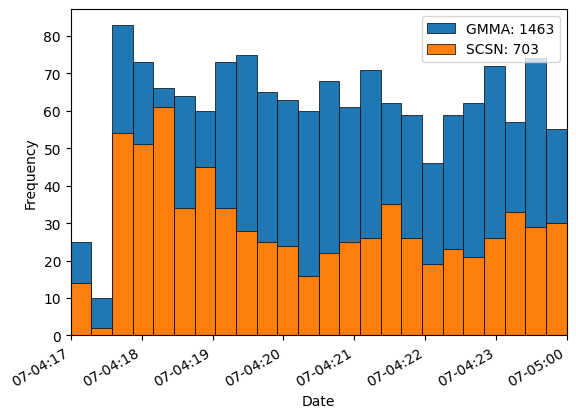

In [8]:
with open(data_dir("config.pkl"), "rb") as fp:
    config = pickle.load(fp)
    
stations = pd.read_csv(data_dir("stations.csv"), delimiter="\t")
events = pd.read_csv(data_dir("events.csv"), delimiter="\t")
events["time"] = events["time"].apply(lambda x: datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%f"))

catalog = pd.read_csv(data_dir("catalog_gamma.csv"), delimiter="\t")
catalog["time"] = catalog["time"].apply(lambda x: datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%f"))
catalog["covariance"] = catalog["covariance"].apply(lambda x: [float(i) for i  in x.split(",")])

plt.figure()
plt.hist(catalog["time"], range=(config["starttime"], config["endtime"]), bins=24, edgecolor="k", alpha=1.0, linewidth=0.5, label=f"{result_label}: {len(catalog['time'])}")
plt.hist(events["time"], range=(config["starttime"], config["endtime"]), bins=24, edgecolor="k", alpha=1.0, linewidth=0.5, label=f"{catalog_label}: {len(events['time'])}")
plt.ylabel("Frequency")
plt.xlabel("Date")
plt.gca().autoscale(enable=True, axis='x', tight=True)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d:%H'))
plt.gcf().autofmt_xdate()
plt.legend()
plt.savefig(figure_dir("earthquake_number.png"), bbox_inches="tight", dpi=300)
plt.savefig(figure_dir("earthquake_number.pdf"), bbox_inches="tight")
plt.show();

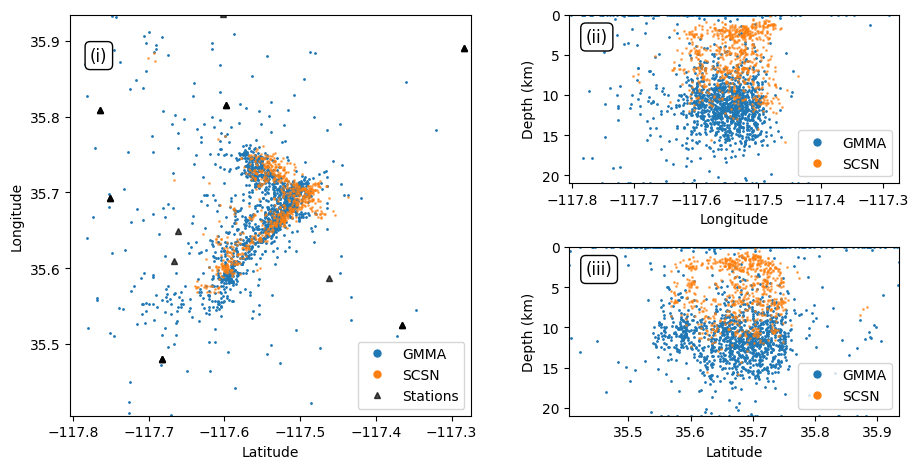

In [9]:
fig = plt.figure(figsize=plt.rcParams["figure.figsize"]*np.array([1.5,1]))
box = dict(boxstyle='round', facecolor='white', alpha=1)
text_loc = [0.05, 0.92]
grd = fig.add_gridspec(ncols=2, nrows=2, width_ratios=[1.5, 1], height_ratios=[1,1])
fig.add_subplot(grd[:, 0])
plt.plot(catalog["longitude"], catalog["latitude"], '.',markersize=2, alpha=1.0)
plt.plot(events["longitude"], events["latitude"], '.', markersize=2, alpha=0.6)
plt.axis("scaled")
plt.xlim(np.array(config["xlim_degree"])+np.array([0.2,-0.27]))
plt.ylim(np.array(config["ylim_degree"])+np.array([0.2,-0.27]))
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.gca().set_prop_cycle(None)
plt.plot(config["xlim_degree"][0]-10, config["ylim_degree"][0]-10, '.', markersize=10, label=f"{result_label}", rasterized=True)
plt.plot(config["xlim_degree"][0]-10, config["ylim_degree"][0]-10, '.', markersize=10, label=f"{catalog_label}", rasterized=True)
plt.plot(stations["longitude"], stations["latitude"], 'k^', markersize=5, alpha=0.7, label="Stations")
plt.legend(loc="lower right")
plt.text(text_loc[0], text_loc[1], '(i)', horizontalalignment='left', verticalalignment="top", 
         transform=plt.gca().transAxes, fontsize="large", fontweight="normal", bbox=box)

fig.add_subplot(grd[0, 1])
plt.plot(catalog["longitude"], catalog["depth(m)"]/1e3, '.', markersize=2, alpha=1.0, rasterized=True)
plt.plot(events["longitude"], events["depth(m)"]/1e3, '.', markersize=2, alpha=0.6, rasterized=True)
# plt.axis("scaled")
plt.xlim(np.array(config["xlim_degree"])+np.array([0.2,-0.27]))
plt.ylim([0,21])
plt.gca().invert_yaxis()
plt.xlabel("Longitude")
plt.ylabel("Depth (km)")
plt.gca().set_prop_cycle(None)
plt.plot(config["xlim_degree"][0]-10, 31, '.', markersize=10, label=f"{result_label}")
plt.plot(31, 31, '.', markersize=10, label=f"{catalog_label}")
plt.legend(loc="lower right")
plt.text(text_loc[0], text_loc[1], '(ii)', horizontalalignment='left', verticalalignment="top", 
         transform=plt.gca().transAxes, fontsize="large", fontweight="normal", bbox=box)

fig.add_subplot(grd[1, 1])
plt.plot(catalog["latitude"], catalog["depth(m)"]/1e3, '.', markersize=2, alpha=1.0, rasterized=True)
plt.plot(events["latitude"], events["depth(m)"]/1e3, '.', markersize=2, alpha=0.6, rasterized=True)
# plt.axis("scaled")
plt.xlim(np.array(config["ylim_degree"])+np.array([0.2,-0.27]))
plt.ylim([0,21])
plt.gca().invert_yaxis()
plt.xlabel("Latitude")
plt.ylabel("Depth (km)")
plt.gca().set_prop_cycle(None)
plt.plot(config["ylim_degree"][0]-10, 31, '.', markersize=10, label=f"{result_label}")
plt.plot(31, 31, '.', markersize=10, label=f"{catalog_label}")
plt.legend(loc="lower right")
plt.tight_layout()
plt.text(text_loc[0], text_loc[1], '(iii)', horizontalalignment='left', verticalalignment="top", 
         transform=plt.gca().transAxes, fontsize="large", fontweight="normal", bbox=box)
plt.savefig(figure_dir("earthquake_location.png"), bbox_inches="tight", dpi=300)
plt.savefig(figure_dir("earthquake_location.pdf"), bbox_inches="tight", dpi=300)
plt.show();

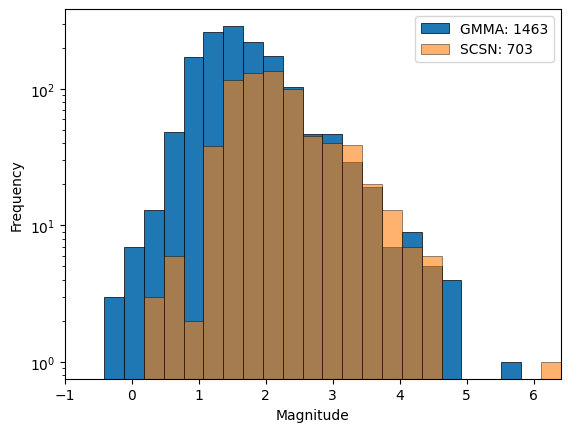

In [10]:
plt.figure()
plt.hist(catalog["magnitude"], range=(-1., events["magnitude"].max()), bins=25, alpha=1.0,  edgecolor="k", linewidth=0.5, label=f"{result_label}: {len(catalog['magnitude'])}")
plt.hist(events["magnitude"], range=(-1., events["magnitude"].max()), bins=25, alpha=0.6,  edgecolor="k", linewidth=0.5, label=f"{catalog_label}: {len(events['magnitude'])}")
plt.legend()
# plt.figure()
plt.xlim([-1,events["magnitude"].max()])
plt.xlabel("Magnitude")
plt.ylabel("Frequency")
plt.gca().set_yscale('log')
plt.savefig(figure_dir("earthquake_magnitude_frequency.png"), bbox_inches="tight", dpi=300)
plt.savefig(figure_dir("earthquake_magnitude_frequency.pdf"), bbox_inches="tight")
plt.show();

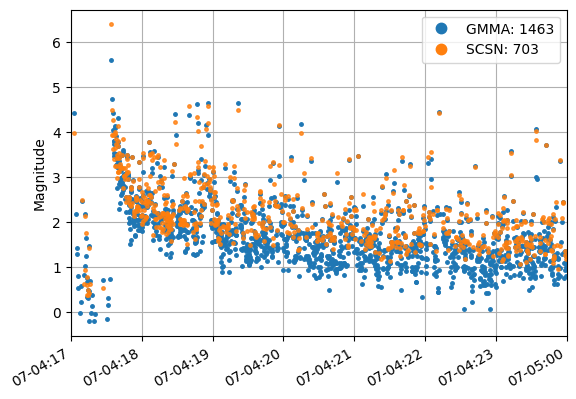

In [11]:
plt.figure()
plt.plot(catalog["time"], catalog["magnitude"], '.', markersize=5, alpha=1.0, rasterized=True)
plt.plot(events["time"], events["magnitude"], '.', markersize=5, alpha=0.8, rasterized=True)
plt.xlim(config["starttime"], config["endtime"])
ylim = plt.ylim()
plt.ylabel("Magnitude")
# plt.xlabel("Date")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d:%H'))
plt.gcf().autofmt_xdate()
plt.gca().set_prop_cycle(None)
plt.plot(config["starttime"], -10, '.', markersize=15, alpha=1.0, label=f"{result_label}: {len(catalog['magnitude'])}")
plt.plot(config["starttime"], -10, '.', markersize=15, alpha=1.0, label=f"{catalog_label}: {len(events['magnitude'])}")
plt.legend()
plt.ylim(ylim)
plt.grid()
plt.savefig(figure_dir("earthquake_magnitude_time.png"), bbox_inches="tight", dpi=300)
plt.savefig(figure_dir("earthquake_magnitude_time.pdf"), bbox_inches="tight", dpi=300)
plt.show();

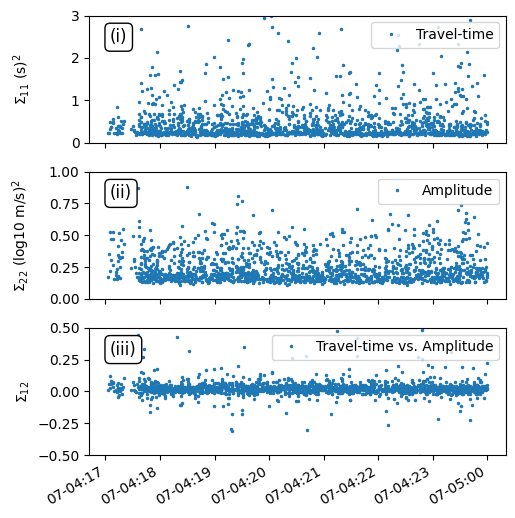

In [38]:
covariance = np.array(catalog["covariance"].to_list())

fig = plt.figure(figsize=plt.rcParams["figure.figsize"]*np.array([0.8,1.1]))
box = dict(boxstyle='round', facecolor='white', alpha=1)
text_loc = [0.05, 0.90]
plt.subplot(311)
plt.plot(catalog["time"], covariance[:,0], '.', markersize=3.0, label="Travel-time")
plt.ylim([0, 3])
plt.ylabel(r"$\Sigma_{11}$ (s)$^2$")
plt.legend(loc="upper right")
plt.text(text_loc[0], text_loc[1], '(i)', horizontalalignment='left', verticalalignment="top", 
         transform=plt.gca().transAxes, fontsize="large", fontweight="normal", bbox=box)
plt.subplot(312)
plt.plot(catalog["time"], covariance[:,1], '.', markersize=3.0, label="Amplitude")
plt.ylim([0, 1])
plt.ylabel(r"$\Sigma_{22}$ ($\log10$ m/s)$^2$")
plt.legend(loc="upper right")
plt.text(text_loc[0], text_loc[1], '(ii)', horizontalalignment='left', verticalalignment="top", 
         transform=plt.gca().transAxes, fontsize="large", fontweight="normal", bbox=box)
plt.subplot(313)
plt.plot(catalog["time"], covariance[:,2], '.', markersize=3.0, label="Travel-time vs. Amplitude")
plt.ylabel(r"$\Sigma_{12}$")
plt.ylim([-0.5, 0.5])
plt.legend(loc="upper right")
plt.text(text_loc[0], text_loc[1], '(iii)', horizontalalignment='left', verticalalignment="top", 
         transform=plt.gca().transAxes, fontsize="large", fontweight="normal", bbox=box)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d:%H'))
plt.gcf().autofmt_xdate()
# plt.suptitle(r"Covariance Matrix ($\Sigma$) Coefficients")
plt.tight_layout()
plt.gcf().align_labels()
plt.savefig(figure_dir("covariance.png"), bbox_inches="tight", dpi=300)
plt.savefig(figure_dir("covariance.pdf"), bbox_inches="tight")
plt.show();